OUT_ROOT: /caefs/user/mmingyeong/2508_slchallence/res/micro_hpo/20250909_004938
Collected 12 trials from: /caefs/user/mmingyeong/2508_slchallence/res/micro_hpo/20250909_004938


,trial,dir,arch,batch,scheduler,warmup_epochs,lr,weight_decay,epochs,patience,val_auc_best,val_auc_best_epoch,val_auc_last,test_auc,test_acc,has_ckpt
0,0,/caefs/user/mmingyeong/2508_slchallence/res/mi...,atto,128,cosine,2,0.000265,0.000071,22,None,0.941198,9,0.927826,0.942405,0.869694,True
1,1,/caefs/user/mmingyeong/2508_slchallence/res/mi...,atto,128,cosine,6,0.000263,0.000034,25,None,0.941980,14,0.931333,0.942573,0.869374,True
2,2,/caefs/user/mmingyeong/2508_slchallence/res/mi...,atto,128,plateau,0,0.000052,0.000200,22,None,0.942415,10,0.923149,0.944074,0.872248,True
3,3,/caefs/user/mmingyeong/2508_slchallence/res/mi...,atto,128,plateau,0,0.000054,0.000120,22,None,0.942415,10,0.924897,0.944074,0.872248,True
4,4,/caefs/user/mmingyeong/2508_slchallence/res/mi...,atto,128,step,0,0.000350,0.000120,22,None,0.942415,10,0.928273,0.944074,0.872248,True
5,5,/caefs/user/mmingyeong/2508_slchallence/res/mi...,atto,128,exp,0,0.000042,0.000190,24,None,0.943241,9,0.921111,0.945220,0.873428,True
6,6,/caefs/user/mmingyeong/2508_slchallence/res/mi...,atto,128,step,0,0.000196,0.000094,22,None,0.942415,10,0.927049,0.944074,0.872248,True
7,7,/caefs/user/mmingyeong/2508_slchallence/res/mi...,atto,128,step,0,0.000350,0.000110,22,None,0.942415,10,0.928273,0.944074,0.872248,True
8,8,/caefs/user/mmingyeong/2508_slchallence/res/mi...,atto,128,plateau,0,0.000037,0.000250,22,None,0.942415,10,0.926106,0.944074,0.872248,True
9,9,/caefs/user/mmingyeong/2508_slchallence/res/mi...,atto,128,plateau,0,0.000077,0.000068,22,None,0.942508,10,0.925471,0.943984,0.871914,True


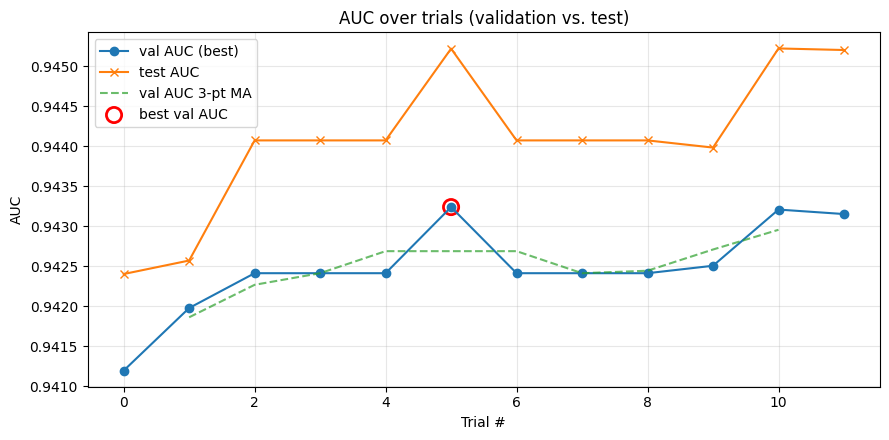

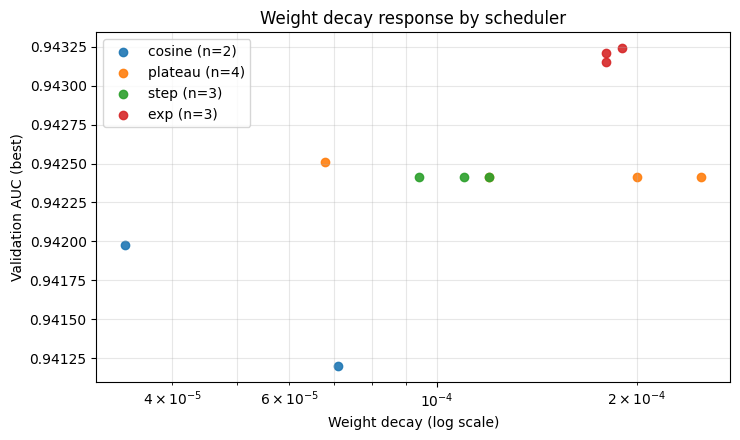

/tmp/ipykernel_43074/2282585764.py:175: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showmeans=True)


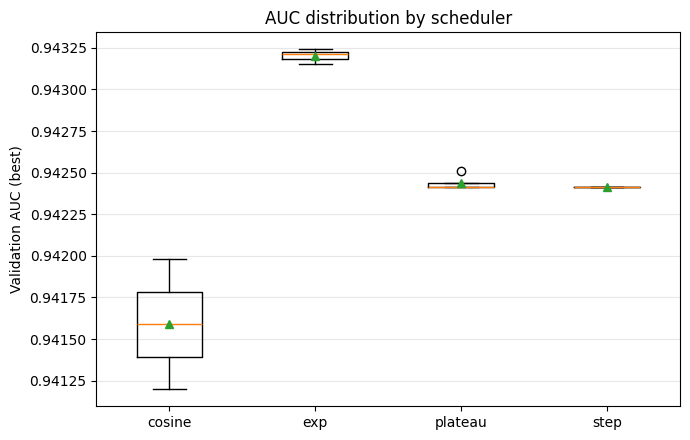

In [1]:
# === Config ===
from pathlib import Path
import re, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# (옵션 1) 가장 최근 마이크로-HPO 런 자동 선택
MICRO_HPO_ROOT = Path("/caefs/user/mmingyeong/2508_slchallence/res/micro_hpo")
OUT_ROOT = max([p for p in MICRO_HPO_ROOT.iterdir() if p.is_dir()], key=lambda p: p.stat().st_mtime)

# (옵션 2) 특정 런을 직접 지정하려면 아래 주석 해제
# OUT_ROOT = Path("/caefs/user/mmingyeong/2508_slchallence/res/micro_hpo/20250908_123456")

print("OUT_ROOT:", OUT_ROOT)
assert OUT_ROOT.exists(), "OUT_ROOT 경로가 존재하지 않습니다."

# ---- helpers ----
def _safe_isna(x):
    return x is None or (isinstance(x, float) and (math.isnan(x)))

def _coalesce(x, default):
    return default if _safe_isna(x) else x

def _read_csv_metrics(csv_path: Path):
    o = dict(val_auc_best=np.nan, val_auc_best_epoch=np.nan,
             val_auc_last=np.nan, lr=np.nan, epochs=np.nan)
    if not csv_path.exists():
        return o
    df = pd.read_csv(csv_path)
    if len(df):
        if "val_auc" in df and "epoch" in df:
            i = df["val_auc"].idxmax()
            o["val_auc_best"]       = float(df["val_auc"].iloc[i])
            o["val_auc_best_epoch"] = int(df["epoch"].iloc[i])
            o["val_auc_last"]       = float(df["val_auc"].iloc[-1])
        if "lr" in df:
            o["lr"] = float(df["lr"].dropna().iloc[-1])
        if "epoch" in df:
            o["epochs"] = int(df["epoch"].max())
    return o

def _read_results_json(res_path: Path):
    out = {}
    if not res_path.exists():
        return out
    with open(res_path, "r") as f:
        data = json.load(f)
    root_like   = data.get("root", data) if isinstance(data, dict) else {}
    config_like = data.get("config", root_like.get("config", {})) if isinstance(data, dict) else {}
    out["test_auc"] = root_like.get("test_auc")
    out["test_acc"] = root_like.get("test_acc")
    for k in ["model_size","model_name","weight_decay","epochs","patience","batch_size","lr","scheduler","warmup_epochs"]:
        if k in config_like:
            out[k] = config_like[k]
    return out

def _parse_trial_name(name: str):
    """
    지원 예:
      trial_005_atto_bs128_schcosine_wd3.0e-04_wu6
      trial_011_atto_bs128_schonecycle_wd1.0e-04
      trial_003_atto_bs128_schnone_wd3.0e-05
    """
    trial = arch = sch = None
    batch = wu = None
    wd = None

    m = re.search(r"trial_(\d+)", name)
    if m: trial = int(m.group(1))

    m = re.search(r"trial_\d+_([A-Za-z0-9\-]+)_bs", name)
    if m: arch = m.group(1)

    m = re.search(r"_bs(\d+)", name)
    if m: batch = int(m.group(1))

    m = re.search(r"_sch([A-Za-z0-9]+)", name)
    if m: sch = m.group(1)

    m = re.search(r"_wd([0-9eE\.\+\-]+)", name)
    if m:
        try: wd = float(m.group(1))
        except: wd = None

    m = re.search(r"_wu(\d+)", name)
    if m: wu = int(m.group(1))

    return trial, arch, batch, sch, wd, wu

# ---- collect trials ----
trial_dirs = sorted([p for p in OUT_ROOT.glob("trial_*") if p.is_dir()],
                    key=lambda p: int(re.search(r"trial_(\d+)", p.name).group(1)))

rows = []
for d in trial_dirs:
    tno, arch, batch, sch, wd_from_name, wu = _parse_trial_name(d.name)
    csvm = _read_csv_metrics(d / "training_log.csv")
    res  = _read_results_json(d / "results.json")

    rows.append({
        "trial": tno,
        "dir": str(d),
        "arch": arch or res.get("model_size") or res.get("model_name"),
        "batch": batch or res.get("batch_size"),
        "scheduler": sch or res.get("scheduler"),
        "warmup_epochs": wu if wu is not None else res.get("warmup_epochs"),
        "lr": _coalesce(csvm["lr"], res.get("lr")),
        "weight_decay": wd_from_name if wd_from_name is not None else res.get("weight_decay"),
        "epochs": _coalesce(csvm["epochs"], res.get("epochs")),
        "patience": res.get("patience"),
        "val_auc_best": csvm["val_auc_best"],
        "val_auc_best_epoch": csvm["val_auc_best_epoch"],
        "val_auc_last": csvm["val_auc_last"],
        "test_auc": res.get("test_auc", np.nan),
        "test_acc": res.get("test_acc", np.nan),
        "has_ckpt": (d / "best.pt").exists(),
    })

df = pd.DataFrame(rows).sort_values("trial").reset_index(drop=True)
print(f"Collected {len(df)} trials from: {OUT_ROOT}")
display(df.head(len(df)))  # 전체 확인 원하면 len(df)로

# (선택) CSV로 저장
(df.sort_values(["val_auc_best","test_auc"], ascending=[False, False])
   .to_csv(OUT_ROOT / "summary_micro_hpo.csv", index=False))

# ---------- Plot 1: AUC over trials (x=trial order) ----------
seq = df.dropna(subset=["val_auc_best"]).sort_values("trial")
plt.figure(figsize=(9, 4.5))
plt.plot(seq["trial"], seq["val_auc_best"], marker="o", label="val AUC (best)")
plt.plot(seq["trial"], seq["test_auc"], marker="x", label="test AUC")
# (optional) moving average for trend
w = 3; ma = seq["val_auc_best"].rolling(w, center=True).mean()
plt.plot(seq["trial"], ma, linestyle="--", alpha=0.7, label=f"val AUC {w}-pt MA")
ib = seq["val_auc_best"].idxmax()
plt.scatter([seq.loc[ib, "trial"]], [seq.loc[ib, "val_auc_best"]],
            s=120, facecolors="none", edgecolors="red", linewidths=2,
            label="best val AUC")
plt.xlabel("Trial #")
plt.ylabel("AUC")
plt.title("AUC over trials (validation vs. test)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Plot 2: weight_decay vs val AUC (log-x), by scheduler ----------
dd = df.copy()
dd["weight_decay"] = pd.to_numeric(dd["weight_decay"], errors="coerce")
dd = dd.dropna(subset=["weight_decay","val_auc_best"])

plt.figure(figsize=(7.5, 4.5))
for sch in dd["scheduler"].dropna().unique():
    m = dd["scheduler"] == sch
    plt.scatter(dd.loc[m, "weight_decay"], dd.loc[m, "val_auc_best"],
                label=f"{sch} (n={m.sum()})", alpha=0.9, marker="o")
plt.xscale("log")
plt.xlabel("Weight decay (log scale)")
plt.ylabel("Validation AUC (best)")
plt.title("Weight decay response by scheduler")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Plot 3: AUC distribution by scheduler (boxplot) ----------
groups, labels = [], []
for sch, g in df.groupby("scheduler"):
    if len(g):
        groups.append(pd.to_numeric(g["val_auc_best"], errors="coerce").dropna().values)
        labels.append(str(sch))

plt.figure(figsize=(7, 4.5))
plt.boxplot(groups, labels=labels, showmeans=True)
plt.ylabel("Validation AUC (best)")
plt.title("AUC distribution by scheduler")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [2]:
summary = (df
  .groupby("scheduler", dropna=False)["val_auc_best"]
  .agg(n="count", best="max", mean="mean", std="std")
  .sort_values("best", ascending=False))
display(summary)


,n,best,mean,std
scheduler,,,,
exp,3,0.943241,0.943202,0.000044
plateau,4,0.942508,0.942438,0.000046
step,3,0.942415,0.942415,0.000000
cosine,2,0.941980,0.941589,0.000553
